In [1]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import json
from PIL import Image
import random
import albumentations as A

/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/.Keypoint_detection_notebooks/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Define a function to visualize keypoints on an image

KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=15):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)
        
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)

In [4]:
# original_images_df_dir = os.path.join(os. getcwd(), 'Kirigami_dataset_1')
# original_images_df_dir = os.path.join(os. getcwd(), 'Kirigami_dataset_2')
# original_images_df_dir = os.path.join(os. getcwd(), 'Kirigami_dataset_3')
original_images_df_dir = os.path.join(os. getcwd(), 'Kirigami_dataset_4')

In [5]:
# original_df = pd.read_csv('./Kirigami_dataset_1/original_kirigami_image_df.csv')
# original_df = pd.read_csv('./Kirigami_dataset_2/Kirigami_dataset_2.csv')
# original_df = pd.read_csv('./Kirigami_dataset_3/Kirigami_dataset_3.csv')
original_df = pd.read_csv('./Kirigami_dataset_4/Kirigami_dataset_4.csv')

In [6]:
# new_images_dir = os.path.join(os. getcwd(), 'Kirigami_dataset_invert')
# new_images_dir = os.path.join(os. getcwd(), 'Kirigami_dataset_2_invert')
# new_images_dir = os.path.join(os. getcwd(), 'Kirigami_dataset_3_invert')
new_images_dir = os.path.join(os. getcwd(), 'Kirigami_dataset_4_invert')

In [8]:
header = ['image_name', 'p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y', 'p5_x', 'p5_y', 'p6_x', 'p6_y', 'p7_x', 'p7_y', 'p8_x', 'p8_y', 'p9_x', 'p9_y', 'p10_x', 'p10_y', 'p11_x', 'p11_y', 'p12_x', 'p12_y', 'p13_x', 'p13_y', 'p14_x', 'p14_y', 'p15_x', 'p15_y', 'p16_x', 'p16_y']
new_images_df = pd.DataFrame(columns=header)

i = 0
repeat = 0

while i < original_df.shape[0]:
    
    transform = A.Compose([
        A.Affine(rotate=180, p=1)
    ], keypoint_params=A.KeypointParams(format='xy'))
    
    
    image_to_be_transformed = cv2.imread(os.path.join(original_images_df_dir, original_df.iloc[i]['image_name']))
    
    x_points = original_df.iloc[i][1:][::2]*image_to_be_transformed.shape[1]
    y_points = original_df.iloc[i][2:][::2]*image_to_be_transformed.shape[0]
    albumentations_keypoints = list(zip(x_points,y_points))
    
#     vis_keypoints(image_to_be_transformed, albumentations_keypoints, color=KEYPOINT_COLOR, diameter=15)
    
    transformed = transform(image=image_to_be_transformed, keypoints=albumentations_keypoints)
    transformed_image = transformed['image']
    transformed_keypoints = transformed['keypoints']
    
    rearranged_transformed_keypoints = [(0,0) for _ in range(16)]
    rearranged_transformed_keypoints[0] = transformed_keypoints[3]#1->4
    rearranged_transformed_keypoints[1] = transformed_keypoints[4]#2->5
    rearranged_transformed_keypoints[2] = transformed_keypoints[5]#3->6
    rearranged_transformed_keypoints[3] = transformed_keypoints[0]#4->1
    rearranged_transformed_keypoints[4] = transformed_keypoints[1]#5->2
    rearranged_transformed_keypoints[5] = transformed_keypoints[2]#6->3
    rearranged_transformed_keypoints[6] = transformed_keypoints[11]#7->12
    rearranged_transformed_keypoints[7] = transformed_keypoints[12]#8->13
    rearranged_transformed_keypoints[8] = transformed_keypoints[13]#9->14
    rearranged_transformed_keypoints[9] = transformed_keypoints[14]#10->15
    rearranged_transformed_keypoints[10] = transformed_keypoints[15]#11->16
    rearranged_transformed_keypoints[11] = transformed_keypoints[6]#12->7
    rearranged_transformed_keypoints[12] = transformed_keypoints[7]#13->8
    rearranged_transformed_keypoints[13] = transformed_keypoints[8]#14->9
    rearranged_transformed_keypoints[14] = transformed_keypoints[9]#15->10
    rearranged_transformed_keypoints[15] = transformed_keypoints[10]#16->11
    
#     vis_keypoints(transformed_image, transformed_keypoints, color=KEYPOINT_COLOR, diameter=15)
    
    if repeat >= 20:
        repeat = 0
        i = i + 1
        continue
    
    if len(transformed_keypoints) != 16:
        print(original_df.iloc[i]['image_name'])
        repeat = repeat + 1
        
        continue
    
    new_image_name = 'I' + original_df.iloc[i]['image_name']
    
    new_images_df.loc[len(new_images_df)] = new_image_name
    
    flatten_coordinates = np.array(rearranged_transformed_keypoints).flatten()  
    flatten_coordinates[::2] = [x / transformed_image.shape[1] for x in flatten_coordinates[::2]]
    flatten_coordinates[1::2] = [x / transformed_image.shape[0] for x in flatten_coordinates[1::2]]
    
    new_images_df.iloc[len(new_images_df)-1, 1:33] = flatten_coordinates
    
    transformed_image[..., [0, 2]] = transformed_image[..., [2, 0]]
    img = Image.fromarray(np.uint8(transformed_image))
    img.save(os.path.join(new_images_dir, new_image_name))
    
    repeat = 0
    i = i + 1
    
    
new_images_df.to_csv(os.path.join(new_images_dir, 'Kirigami_dataset_4_invert.csv'), index=False)

print("Finished")

Finished


In [9]:
print(new_images_df.head(3))

       image_name      p1_x      p1_y      p2_x      p2_y      p3_x      p3_y  \
0  Iimage0240.jpg  0.219511  0.361917  0.512811  0.156523   0.81422  0.324982   
1  Iimage0241.jpg  0.209474   0.36074  0.511487  0.156962  0.823941  0.324954   
2  Iimage0242.jpg  0.195461   0.35992  0.510131  0.156707  0.838267  0.317387   

       p4_x      p4_y      p5_x  ...     p12_x     p12_y     p13_x     p13_y  \
0  0.821385  0.649632   0.52903  ...   0.53714   0.75739  0.532409  0.624965   
1  0.828415  0.657956  0.525656  ...  0.537587  0.759348  0.533859  0.629129   
2  0.843228  0.663323  0.525723  ...  0.546276  0.761622  0.546276  0.628351   

      p14_x     p14_y     p15_x     p15_y     p16_x     p16_y  
0  0.531733   0.50245  0.525651  0.377232  0.522272  0.243906  
1  0.536096  0.499905   0.53013   0.37565  0.525656  0.242449  
2  0.548402  0.499807  0.541315  0.370317  0.534936  0.237992  

[3 rows x 33 columns]


In [10]:
current_dir = os. getcwd()
images_dir = os.path.join(current_dir, 'Kirigami_dataset_4_invert')

In [11]:
img_idx = 42

In [12]:
new_images_df.iloc[img_idx]['image_name']

'Iimage0282.jpg'

In [13]:
img_arr = cv2.imread(os.path.join(images_dir, new_images_df.iloc[img_idx]['image_name']))

In [14]:
img_arr.shape

(480, 640, 3)

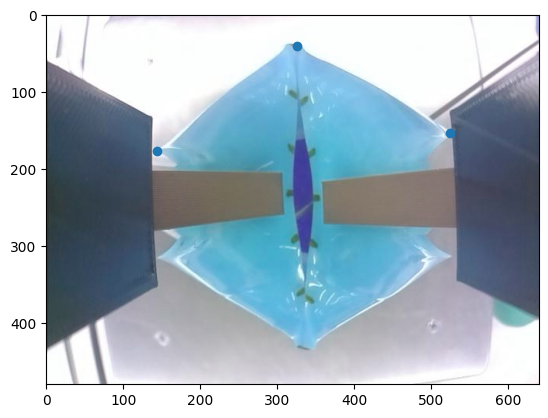

In [15]:
plt.imshow(img_arr)
x_points = new_images_df.iloc[img_idx][1:7][::2]
y_points = new_images_df.iloc[img_idx][2:8][::2]
x_width = img_arr.shape[1]
y_height = img_arr.shape[0]

plt.scatter(x_points*x_width, y_points*y_height)
# plt.scatter(x_points, y_points)